# Analyzer of Stocks


## Libraries


In [1]:
# Import necessary libraries
from dotenv import load_dotenv
from libs import indicators, signals
import alpaca_trade_api as trade_api
import os
import pandas as pd
import matplotlib.pyplot as plt


## Alpaca Connection


In [2]:
load_dotenv()


True

In [3]:
# Get keys and URL for Alpaca API
alpaca_key = os.getenv('APCA_API_KEY_ID')
alpaca_secret_key = os.getenv('APCA_API_SECRET_KEY')
alpaca_paper_trade_url = os.getenv('APCA_API_PAPER_URL')


In [4]:
# Instantiate Alpaca connection
alpaca = trade_api.REST(alpaca_key, alpaca_secret_key, base_url=alpaca_paper_trade_url)


In [5]:
# Default parameters
ticker = 'TWOU'

today = pd.Timestamp('today')
today_date = f'{today:%Y-%m-%d}'

start_date = pd.Timestamp('2018-01-01', tz='America/New_York').isoformat()

end_date = pd.Timestamp(today_date, tz='America/New_York').isoformat()

timeframe = '1D'


In [6]:
# Get dataframe of ticker data
df_ohlcv_original = alpaca.get_barset(ticker, timeframe, start=start_date, end=end_date).df

# Copy of original dataframe
df_ohlcv = df_ohlcv_original[ticker].copy()


## Bollinger Bands


In [7]:
# Generate Bollinger Band data
df_updated = indicators.bollinger_band_generator(df_ohlcv)


## Keltner Channels


In [8]:
# Generate average true range values
df_updated = indicators.keltner_channel_generator(df_updated)


## EWMA (Fast and Slow)


In [9]:
# Generate ewma values
# Default fast = 12 and slow = 25.  Increase sensitivity: fast = 5 and slow = 35
df_updated = indicators.ewma_generator(df_updated, 5, 35)


## MACD 


In [10]:
# Generate macd values
df_updated = indicators.macd_generator(df_updated)


In [11]:
# Drop nan values
df_updated.dropna(inplace=True)


## Bollinger Bands and Keltner Channels Indicators Plot


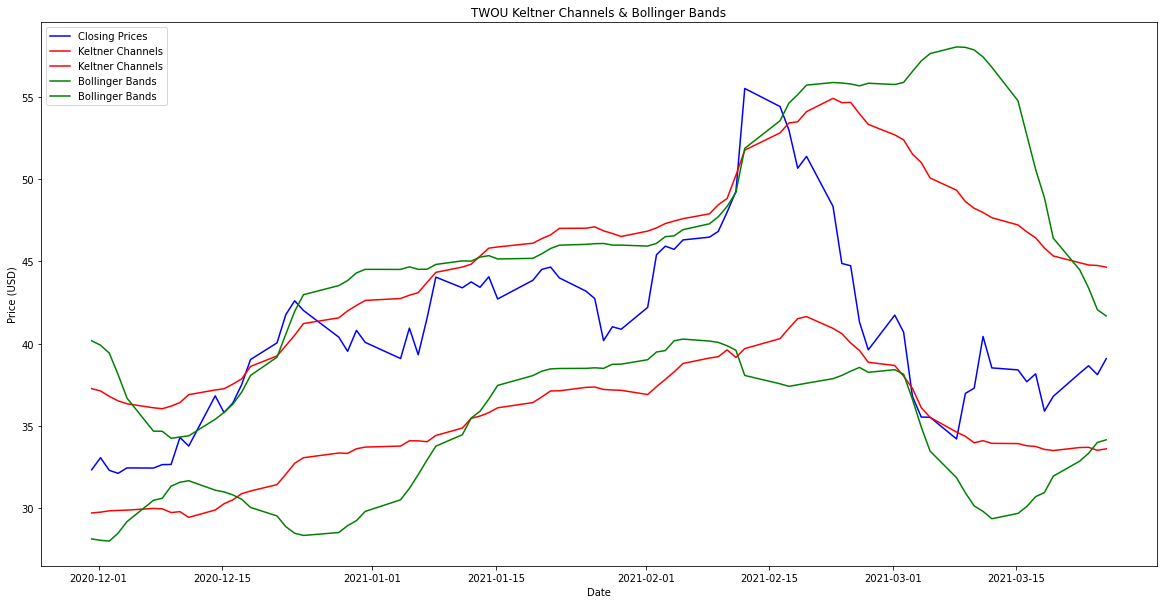

In [12]:
# Generate Keltner Channels and Bollinger Bands plot
plt.figure(figsize=(20,10))
plt.title(f'{ticker} Keltner Channels & Bollinger Bands')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.plot(df_updated[['close']], color='b', label='Closing Prices')
plt.plot(df_updated[['kc_upper', 'kc_lower']], color="r", label='Keltner Channels')
plt.plot(df_updated[['bb_upper', 'bb_lower']], color="g", label='Bollinger Bands')
plt.legend(loc='upper left')


## Exponential Weighted Moving Average (EWMA) Plot


<AxesSubplot:title={'center':'EWMA Fast and Slow'}, xlabel='Date', ylabel='Price (USD)'>

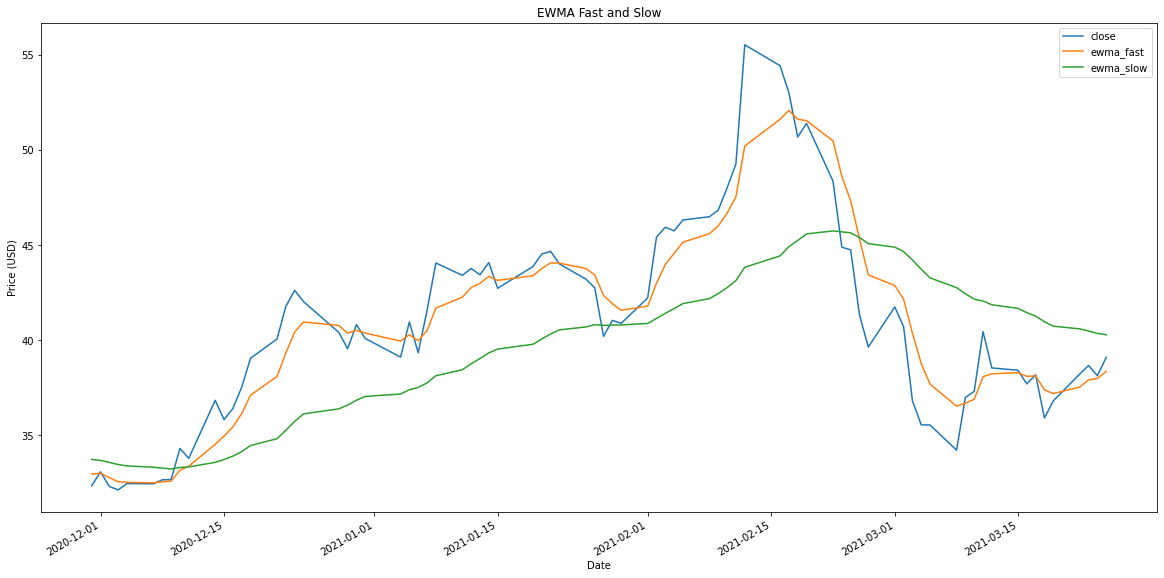

In [13]:
# Generate MACD Fast and Slow plot
df_updated[['close', 'ewma_fast', 'ewma_slow']].plot(figsize=(20,10), title='EWMA Fast and Slow', xlabel='Date', ylabel='Price (USD)')


In [14]:
df_updated = signals.bbands_inside_kchannels(df_updated)
df_updated = signals.ewma_crossovers(df_updated)
df_updated = signals.macd(df_updated, 5)


## MACD Signals


<AxesSubplot:title={'center':'MACD Signal With Divergence'}, xlabel='Date', ylabel='Amount of Divergence'>

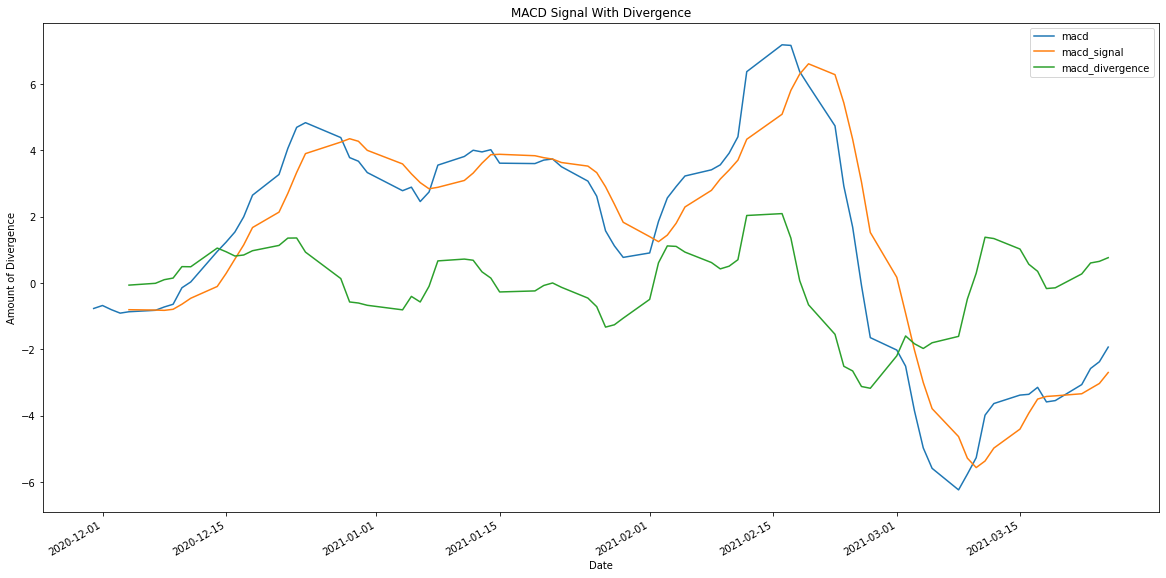

In [15]:
# Generate MACD with signal and divergence lines
df_updated[['macd', 'macd_signal', 'macd_divergence']].plot(figsize=(20,10), title='MACD Signal With Divergence', xlabel='Date', ylabel='Amount of Divergence')


In [16]:
# Drop nan values
df_updated.dropna(inplace=True)


In [17]:
# Display dataframe
df_updated.head()


,open,high,low,close,volume,bb_upper,bb_middle,bb_lower,atr,kc_upper,kc_middle,kc_lower,ewma_fast,ewma_slow,macd,bbkc_squeeze,ewma_crossover_signal,macd_signal,macd_divergence
time,,,,,,,,,,,,,,,,,,,
2020-12-04 00:00:00-05:00,32.49,33.1499,32.37,32.45,549840,36.693524,32.93775,29.181976,1.616738,36.349574,33.116098,29.882623,32.515787,33.379816,-0.864029,0.0,0.0,-0.802582,-0.061447
2020-12-07 00:00:00-05:00,32.44,33.6000,32.39,32.44,832128,34.684931,32.58225,30.479569,1.529938,36.105839,33.045963,29.986086,32.490524,33.311156,-0.820632,1.0,0.0,-0.813579,-0.007054
2020-12-08 00:00:00-05:00,32.44,32.9400,32.16,32.65,892285,34.677702,32.64125,30.604798,1.521716,36.048665,33.005233,29.961802,32.543684,33.263685,-0.720001,1.0,0.0,-0.822363,0.102362
2020-12-09 00:00:00-05:00,33.00,34.0500,32.60,32.66,872223,34.248010,32.79375,31.339490,1.616988,36.203968,32.969991,29.736014,32.582457,33.221033,-0.638576,1.0,0.0,-0.789830,0.151254
2020-12-10 00:00:00-05:00,32.28,34.4350,31.98,34.30,639748,34.327495,32.95325,31.579005,1.657849,36.420538,33.104839,29.789141,33.154978,33.296131,-0.141153,1.0,0.0,-0.636878,0.495725
